In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import BinaryEncoder
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_score

In [33]:
X = pd.read_csv('/kaggle/input/regression-using-nn/X.csv', index_col = False)
y = pd.read_csv('/kaggle/input/regression-using-nn/y.csv', index_col = False)

In [34]:
X = X.drop(X.columns[0], axis=1)
y = y.drop(y.columns[0], axis=1)

In [99]:
print(X.shape)
X.columns


(4419, 29)


Index(['HUC8_0', 'HUC8_1', 'HUC8_2', 'HUC8_3', 'HUC8_4', 'HUC8_5', 'year_0',
       'year_1', 'year_2', 'year_3', 'year_4', 'Lagged_spi1',
       'previous_winter_spi1', 'previous_winter_spi12',
       'Slope..Mean.Value.in.HUC8.Watershed',
       'Elevation..Mean.Value.in.HUC8.Watershed',
       'Mean.Annual.Precipitation..1981.2010..in.Watershed',
       'Soil.Stability..Mean.in.WS', 'X..Urban.in.WS..2016.',
       'X..Agriculture.in.WS..2016.', 'X..Cultivated.Crops.in.WS..2016.',
       'X..Agriculture.on...20..Slope.in.WS..2016.',
       'X..Slope.of.Cropland..Mean.in.WS..2016.',
       'X..Cropland.on...10..Slope.in.WS..2016.',
       'X..Imperviousness..Mean.in.WS..2016.', 'Population.Density.in.WS',
       'Synthetic.N.Fertilizer.Application.in.WS', 'month_sin', 'month_cos'],
      dtype='object')

In [96]:
X.head()

,HUC8_0,HUC8_1,HUC8_2,HUC8_3,HUC8_4,HUC8_5,year_0,year_1,year_2,year_3,...,X..Agriculture.in.WS..2016.,X..Cultivated.Crops.in.WS..2016.,X..Agriculture.on...20..Slope.in.WS..2016.,X..Slope.of.Cropland..Mean.in.WS..2016.,X..Cropland.on...10..Slope.in.WS..2016.,X..Imperviousness..Mean.in.WS..2016.,Population.Density.in.WS,Synthetic.N.Fertilizer.Application.in.WS,month_sin,month_cos
0,0,0,0,0,0,1,0,0,0,0,...,3.171821,0.260322,0.001113,1.700216,0.001364,0.123372,0.101141,0.979780,-0.866025,-0.500000
1,0,0,0,0,0,1,0,0,0,1,...,3.171821,0.260322,0.001113,1.700216,0.001364,0.123372,0.101141,0.979780,0.500000,-0.866025
2,0,0,0,0,1,0,0,0,0,1,...,7.241330,3.257066,0.001781,1.667374,0.041926,0.292019,2.472286,2.240497,-0.500000,-0.866025
3,0,0,0,0,1,0,0,0,0,1,...,7.241330,3.257066,0.001781,1.667374,0.041926,0.292019,2.472286,2.240497,-0.866025,-0.500000
4,0,0,0,0,1,0,0,0,1,0,...,7.241330,3.257066,0.001781,1.667374,0.041926,0.292019,2.472286,2.240497,-0.866025,-0.500000


In [36]:
#Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#Feature Scaling -- for better training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [38]:
!pip install --no-deps scikeras

In [39]:
def create_model_tunning(activation, learning_rate, optimizer = 'adam', **kwargs):
    # Create model
    model = Sequential([
    Dense(160, input_dim = X_train_scaled.shape[1], activation=activation),
    Dropout(0.2),
    Dense(480, activation=activation),
    Dropout(0.2),
    Dense(256, activation=activation),
    Dense(1, activation='linear')  # Output layer
    ])    
    # Choose optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    return model

In [40]:
from scikeras.wrappers import KerasRegressor
model_tunning = KerasRegressor(build_fn = create_model_tunning , learning_rate = 0.01,  activation= 'relu')
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'sgd'],
}

# Use GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator = model_tunning, param_grid = param_grid, cv=3, scoring = 'neg_root_mean_squared_error', error_score='raise', n_jobs = -1, verbose = 1)
grid_result = grid.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 43.3053 - mse: 43.3053
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 36.3672 - mse: 36.3672
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 35.6727 - mse: 35.6727
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 33.4708 - mse: 33.4708
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 33.9848 - mse: 33.9848
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 32.9118 - mse: 32.9118
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 30.9826 - mse: 30.9826
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 32.8080 - mse: 32.8080
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 32.8706 - mse: 32.8706
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 31.2712 - mse: 31.2712


In [41]:
# Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Best: -5.696376343546901 using {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam'}
56/56 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 73.65522173136303
Root Mean Squared Error (RMSE): 82.56994909298952
R² Score: -161.8637547870058


# Creating NN models

In [42]:
def create_model():
    model = Sequential([
      Dense(160, input_dim = 29, activation='relu'),
      Dropout(0.2),
      Dense(480, activation='relu'),
      Dropout(0.2),
      Dense(256, activation='relu'),
      Dense(1, activation='linear')  # Output layer for binary classification
  ])
    return model
nn_model = create_model()
nn_model.compile(loss='mean_squared_error', optimizer=Adam(0.01), metrics=['mse'])
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 160)               4800      
                                                                 
 dropout_2 (Dropout)         (None, 160)               0         
                                                                 
 dense_5 (Dense)             (None, 480)               77280     
                                                                 
 dropout_3 (Dropout)         (None, 480)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               123136    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 205,473
Trainable params: 205,473
Non-tr

In [43]:
history = nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs =10, batch_size = 16)

Epoch 1/10
177/177 [==============================] - 1s 4ms/step - loss: 45.3115 - mse: 45.3115 - val_loss: 40.0226 - val_mse: 40.0226
Epoch 2/10
177/177 [==============================] - 1s 3ms/step - loss: 36.8894 - mse: 36.8894 - val_loss: 42.1936 - val_mse: 42.1936
Epoch 3/10
177/177 [==============================] - 1s 3ms/step - loss: 35.7349 - mse: 35.7349 - val_loss: 33.2090 - val_mse: 33.2090
Epoch 4/10
177/177 [==============================] - 1s 3ms/step - loss: 34.9079 - mse: 34.9079 - val_loss: 34.3952 - val_mse: 34.3952
Epoch 5/10
177/177 [==============================] - 1s 3ms/step - loss: 33.8503 - mse: 33.8503 - val_loss: 32.4060 - val_mse: 32.4060
Epoch 6/10
177/177 [==============================] - 1s 3ms/step - loss: 31.3683 - mse: 31.3683 - val_loss: 34.1932 - val_mse: 34.1932
Epoch 7/10
177/177 [==============================] - 1s 3ms/step - loss: 32.9472 - mse: 32.9472 - val_loss: 30.5901 - val_mse: 30.5901
Epoch 8/10
177/177 [============================

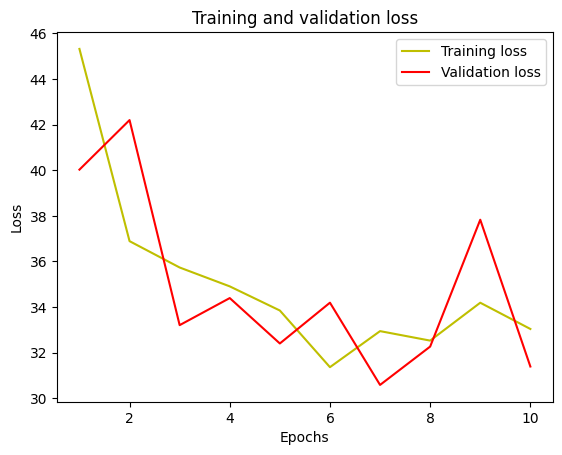

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### This graphs shows that the model gets overfitted.

In [45]:
#Predict on test data
predictions = nn_model.predict(X_test_scaled[:5])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])

1/1 [==============================] - 0s 55ms/step
Predicted values are:  [[5.339743 ]
 [9.004566 ]
 [6.4519744]
 [3.9775167]
 [7.1018543]]
Real values are:        mean.gw.nit
1042     4.766667
1272    11.821429
1918     7.541176
1896     3.096053
4066     5.750000


In [46]:
mse_neural, mae_neural = nn_model.evaluate(X_test_scaled, y_test)
y_pred = nn_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error from neural net: ', np.sqrt(mse_neural))
print('Mean absolute error from neural net: ', mae_neural)
print(f"R² Score: {r2:.4f}")

28/28 [==============================] - 0s 1ms/step
Root Mean squared error from neural net:  5.101460991823679
Mean absolute error from neural net:  26.024904251098633
R² Score: 0.3783


## 2nd Model

In [47]:
nn_model2 = create_model()
nn_model2.compile(loss='mean_squared_error', optimizer=Adam(0.001), metrics=['mse'])
nn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 160)               4800      
                                                                 
 dropout_4 (Dropout)         (None, 160)               0         
                                                                 
 dense_9 (Dense)             (None, 480)               77280     
                                                                 
 dropout_5 (Dropout)         (None, 480)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               123136    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 205,473
Trainable params: 205,473
Non-tr

In [48]:
history = nn_model2.fit(X_train_scaled, y_train, validation_split=0.2, epochs =10, batch_size = 64)

Epoch 1/10
45/45 [==============================] - 1s 7ms/step - loss: 47.3557 - mse: 47.3557 - val_loss: 36.4674 - val_mse: 36.4674
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 35.3293 - mse: 35.3293 - val_loss: 35.5212 - val_mse: 35.5212
Epoch 3/10
45/45 [==============================] - 0s 4ms/step - loss: 32.8433 - mse: 32.8433 - val_loss: 33.5256 - val_mse: 33.5256
Epoch 4/10
45/45 [==============================] - 0s 4ms/step - loss: 32.3570 - mse: 32.3570 - val_loss: 31.2990 - val_mse: 31.2990
Epoch 5/10
45/45 [==============================] - 0s 4ms/step - loss: 30.1220 - mse: 30.1220 - val_loss: 30.7236 - val_mse: 30.7236
Epoch 6/10
45/45 [==============================] - 0s 4ms/step - loss: 29.2695 - mse: 29.2695 - val_loss: 31.7725 - val_mse: 31.7725
Epoch 7/10
45/45 [==============================] - 0s 5ms/step - loss: 28.7277 - mse: 28.7277 - val_loss: 32.0395 - val_mse: 32.0395
Epoch 8/10
45/45 [==============================] - 0s 4ms/ste

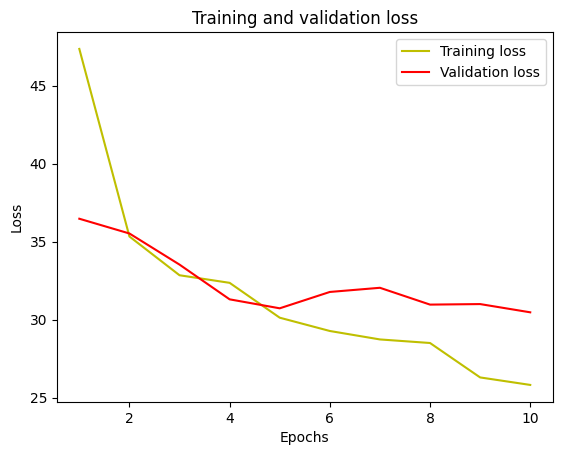

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
mse_neural, mae_neural = nn_model2.evaluate(X_test_scaled, y_test)
y_pred = nn_model2.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error from neural net: ', np.sqrt(mse_neural))
print('Mean absolute error from neural net: ', mae_neural)
print(f"R² Score: {r2:.4f}")

28/28 [==============================] - 0s 1ms/step
Root Mean squared error from neural net:  5.0534764627067235
Mean absolute error from neural net:  25.53762435913086
R² Score: 0.3900


In [101]:
#Predict on test data
predictions = nn_model2.predict(X_test_scaled[:5])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])

1/1 [==============================] - 0s 19ms/step
Predicted values are:  [[5.1035175]
 [9.426928 ]
 [5.332053 ]
 [3.5379558]
 [6.97604  ]]
Real values are:        mean.gw.nit
1042     4.766667
1272    11.821429
1918     7.541176
1896     3.096053
4066     5.750000


### 3rd Model

In [64]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best model weights
)

In [92]:
nn_model3 = create_model()
nn_model3.compile(loss='mean_squared_error', optimizer=Adam(0.001), metrics=['mse'])
nn_model3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 160)               4800      
                                                                 
 dropout_30 (Dropout)        (None, 160)               0         
                                                                 
 dense_61 (Dense)            (None, 480)               77280     
                                                                 
 dropout_31 (Dropout)        (None, 480)               0         
                                                                 
 dense_62 (Dense)            (None, 256)               123136    
                                                                 
 dense_63 (Dense)            (None, 1)                 257       
                                                                 
Total params: 205,473
Trainable params: 205,473
Non-t

In [93]:
history = nn_model3.fit(X_train_scaled, y_train, validation_split=0.2, epochs =10, batch_size = 128, callbacks = [early_stopping])

Epoch 1/10
23/23 [==============================] - 1s 11ms/step - loss: 54.6783 - mse: 54.6783 - val_loss: 43.2333 - val_mse: 43.2333
Epoch 2/10
23/23 [==============================] - 0s 6ms/step - loss: 38.6679 - mse: 38.6679 - val_loss: 39.1028 - val_mse: 39.1028
Epoch 3/10
23/23 [==============================] - 0s 6ms/step - loss: 35.9985 - mse: 35.9985 - val_loss: 35.3635 - val_mse: 35.3635
Epoch 4/10
23/23 [==============================] - 0s 6ms/step - loss: 33.2305 - mse: 33.2305 - val_loss: 33.8114 - val_mse: 33.8114
Epoch 5/10
23/23 [==============================] - 0s 6ms/step - loss: 32.2799 - mse: 32.2799 - val_loss: 34.5652 - val_mse: 34.5652
Epoch 6/10
23/23 [==============================] - 0s 6ms/step - loss: 31.2724 - mse: 31.2724 - val_loss: 32.4244 - val_mse: 32.4244
Epoch 7/10
23/23 [==============================] - 0s 6ms/step - loss: 30.2241 - mse: 30.2241 - val_loss: 33.2269 - val_mse: 33.2269
Epoch 8/10
23/23 [==============================] - 0s 6ms/st

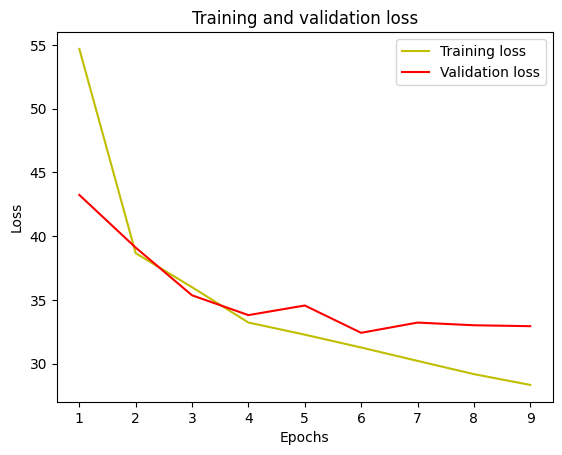

In [94]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
mse_neural, mae_neural = nn_model3.evaluate(X_test_scaled, y_test)
y_pred = nn_model3.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error from neural net: ', np.sqrt(mse_neural))
print('Mean absolute error from neural net: ', mae_neural)
print(f"R² Score: {r2:.4f}")

28/28 [==============================] - 0s 1ms/step
Root Mean squared error from neural net:  5.083816484514147
Mean absolute error from neural net:  25.845190048217773
R² Score: 0.3826


In [102]:
#Predict on test data
predictions = nn_model3.predict(X_test_scaled[:5])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])

1/1 [==============================] - 0s 18ms/step
Predicted values are:  [[6.030491 ]
 [8.241672 ]
 [6.685024 ]
 [4.7719336]
 [6.45698  ]]
Real values are:        mean.gw.nit
1042     4.766667
1272    11.821429
1918     7.541176
1896     3.096053
4066     5.750000


### So the best parameter would be learning_rate = 0.001, epochs =10, and batch_size = 64